
# Modelling

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import json
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

from sklearn.svm import SVC
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set()

In [314]:

def plot_decision_boundary(model, df,dependent, variable1,variable2,sample=1):
    
    plot_df=df.loc[:,[variable1,variable2,dependent]]
    
    model.fit(plot_df.loc[:,[variable1,variable2]].to_numpy(),plot_df[dependent].to_numpy())

    plot_df=plot_df.sample(frac=sample,random_state=1)
   
    fig,ax=plt.subplots(1,figsize=(10,10))

    ax=plot_decision_regions(X=plot_df.loc[:,[variable1,variable2]].to_numpy(), y= plot_df[dependent].to_numpy(), clf=model, legend=2)
    ax.set_xlabel(variable1)
    ax.set_ylabel(variable2)
    
    return fig,ax

# plot_decision_boundary(model,X,"Loan Status","Annual Income","Loan Amount",0.01)




In [315]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

def cross_validate(model,df_independent,df_dependent,type,n=5):
    if type=="Leave One Out":
        loo = LeaveOneOut()
        scores = cross_val_score(model, df_independent, df_dependent, cv=loo, n_jobs=4)
        return scores.mean()
    elif type=="KFold":
        scores = cross_val_score(model, df_independent, df_dependent, cv=n,n_jobs=4)
        return scores.mean()
    elif type=="Holdout":
        x_r, x__s, y_r, y_s =  train_test_split(df_independent,df_dependent,training_size=0.6, test_size=0.4)
        score=model.score(x_r,y_r)
        return score

In [316]:
def ROC(fit_model,df_dependent_test,df_independent_test,param_set=None):
    if hasattr(fit_model,"decision_function"):
        y_score=fit_model.decision_function(df_independent_test)
        fpr, tpr, thresholds = roc_curve(df_dependent_test, y_score)
    elif hasattr(fit_model,"proba"):
        y_score=fit_model.proba(df_independent_test)[:,1]
        fpr, tpr, thresholds = roc_curve(df_dependent_test, y_score)
    else:
        y_score=fit_model.predict_proba(df_independent_test)[:,1]
        fpr, tpr, thresholds = roc_curve(df_dependent_test, y_score)
    if param_set==None:
        name=print_classifier(fit_model["clf"])+classifier_params_tostr(fit_model["clf"],["kernel","class_weight"])
    else:
        name=print_classifier(fit_model["clf"])+classifier_params_tostr(fit_model["clf"],param_set)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,label=name)
#     plt.label(name)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [317]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    
    ax.set_title("Grid Search Scores")
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('CV Average Score')
    ax.legend(loc="best")
    ax.grid('on')

In [318]:
training_for_prediction = pd.read_csv("../data/training_for_prediction_numerical.csv")
test_for_prediction = pd.read_csv("../data/test_for_prediction_numerical.csv")

n=training_for_prediction.loc[training_for_prediction["Loan Status"]==0].shape[0]

# training_prediction_upsampled = np.random.choice(training_for_prediction, size=n, replace=True)

# training_prediction_upsampled.describe

y_test=test_for_prediction.loc[:,"Loan Status"].astype(int)
x_test=test_for_prediction.loc[:,[x for x in training_for_prediction.columns if x !="Loan Status"]]
y_train=training_for_prediction.loc[:,"Loan Status"].astype(int)
x_train=training_for_prediction.loc[:,[x for x in training_for_prediction.columns if x !="Loan Status"]]

In [319]:
def print_classifier(model):
    return type(model).__name__

In [320]:
def classifier_params_tostr(model,variables):
    str_list=[model.get_params()[x] for x in model.get_params().keys() if x in variables]
    s=json.dumps([a for a in str_list if a !='[null]'])\
    .replace("\\","")\
    .replace("null,","")\
    .replace(",null","")\
    .replace("null","")\
    .replace("\"[]\"","")\
    .replace("[]","")\
    .replace(" ","")
    return s

In [321]:
classifier_pipes = dict() 

classifiers = [
    LogisticRegression(),
    LogisticRegression(class_weight="balanced"),
    SVC(kernel="rbf", C=1),
    SVC(kernel="rbf",class_weight="balanced", C=1),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(max_depth=5,class_weight="balanced"),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RandomForestClassifier(max_depth=5,class_weight="balanced", n_estimators=10, max_features=1)]

parameters_set=["kernel","class_weight"]

for classifier in classifiers:
    ss=classifier_params_tostr(classifier,parameters_set)
    classifier_pipes[print_classifier(classifier)+ss]=Pipeline([('scale', StandardScaler()),
    ('clf', classifier)])

In [322]:
classifier_pipes.keys()

dict_keys(['LogisticRegression', 'LogisticRegression["balanced"]', 'SVC["rbf"]', 'SVC["balanced","rbf"]', 'DecisionTreeClassifier', 'DecisionTreeClassifier["balanced"]', 'RandomForestClassifier', 'RandomForestClassifier["balanced"]'])

In [323]:
%%time
models_fit=dict()
models_score=dict()
for pipe,classifier in classifier_pipes.items():
    models_fit[pipe]=classifier.fit(x_train, y_train)
    models_score[pipe]=classifier.score(x_train,y_train)
    

Wall time: 2min 52s


In [324]:
models_score

{'LogisticRegression': 0.8613354786806114,
 'LogisticRegression["balanced"]': 0.6466934835076428,
 'SVC["rbf"]': 0.861560740144811,
 'SVC["balanced","rbf"]': 0.6745615446500403,
 'DecisionTreeClassifier': 0.8626548672566372,
 'DecisionTreeClassifier["balanced"]': 0.6291874497184232,
 'RandomForestClassifier': 0.8613354786806114,
 'RandomForestClassifier["balanced"]': 0.6842156074014482}

Text(0.5, 1.0, 'LogisticRegression')

Text(0.5, 1.0, 'LogisticRegression["balanced"]')

Text(0.5, 1.0, 'SVC["rbf"]')

Text(0.5, 1.0, 'SVC["balanced","rbf"]')

Text(0.5, 1.0, 'DecisionTreeClassifier')

Text(0.5, 1.0, 'DecisionTreeClassifier["balanced"]')

Text(0.5, 1.0, 'RandomForestClassifier')

Text(0.5, 1.0, 'RandomForestClassifier["balanced"]')

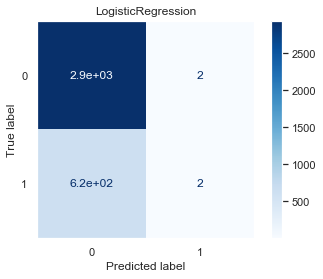

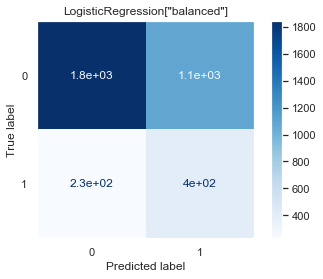

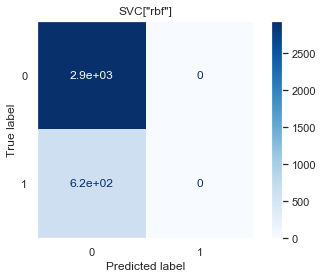

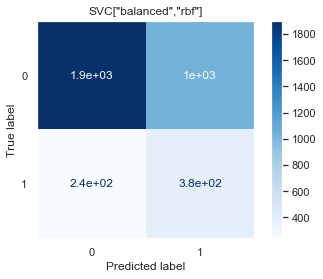

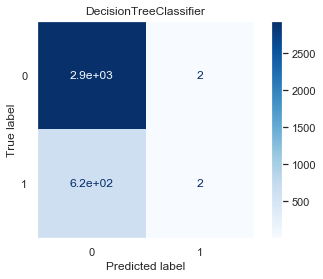

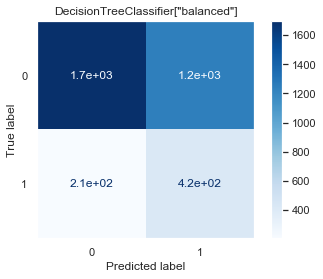

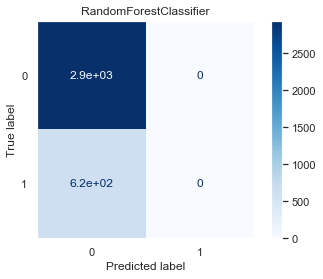

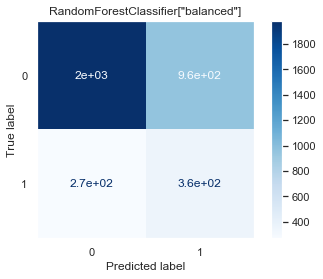

In [325]:
for name,model in models_fit.items():
    ax=metrics.plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)
    ax.ax_.set_title(name)
    plt.grid(None)

    

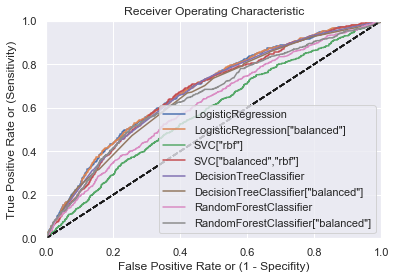

In [326]:
for name,model in models_fit.items():
    ROC(model,y_test,x_test)


In [360]:
rf_param_grid = [
    {'clf':[RandomForestClassifier(class_weight="balanced", max_features=1)],
    'clf__n_estimators' : [10,15,20,50,100],
    'clf__max_depth' : [2,5,10,20,50,100]}]

rf_grid = GridSearchCV(classifier_pipes["RandomForestClassifier"], param_grid = rf_param_grid, cv = 5, verbose=True, n_jobs=-1)


In [347]:
classifier_pipes["RandomForestClassifier"].get_params()

{'memory': None,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=5, max_features=1,
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_jobs=None, oob_score=False, random_state=None,
                          verbose=0, warm_start=False))],
 'verbose': False,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=5, max_features=1,
                        max_leaf_nodes=None, max_samples=None,
                        mi

In [361]:
best_rf=rf_grid.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   18.1s finished


In [351]:
best_rf.best_estimator_["clf"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 1,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [353]:
print_classifier(best_rf.best_estimator_["clf"])+classifier_params_tostr(best_rf.best_estimator_["clf"],['max_depth','n_estimators'])

'RandomForestClassifier[50,50]'

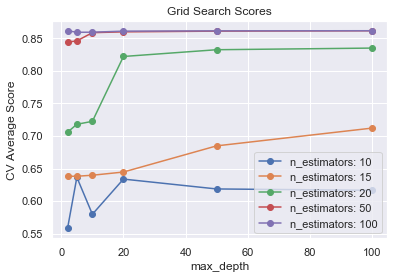

In [363]:
clf__max_depth =[2,5,10,20,50,100]
clf__n_estimators =[10,15,20,50,100]
plot_grid_search(best_rf.cv_results_, clf__max_depth,clf__n_estimators, 'max_depth', 'n_estimators')

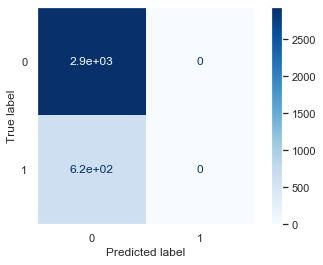

In [364]:
metrics.plot_confusion_matrix(best_rf.best_estimator_,x_test,y_test,cmap=plt.cm.Blues)
plt.grid(None)

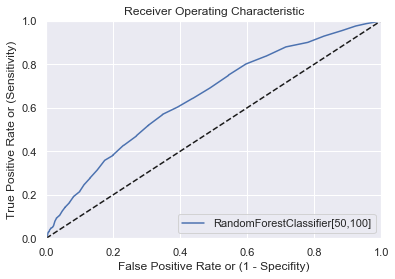

In [365]:
ROC(best_rf.best_estimator_,y_test,x_test,['max_depth', 'n_estimators'])

In [367]:
best_rf.best_estimator_

{'memory': None,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                          criterion='gini', max_depth=50, max_features=1,
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_jobs=None, oob_score=False, random_state=None,
                          verbose=0, warm_start=False))],
 'verbose': False,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=50, max_features=1,
                        max_leaf_nodes=None, max_samples=None,
           

In [335]:
sorted(classifier_pipes["SVC[\"rbf\"]"].get_params())

['clf',
 'clf__C',
 'clf__break_ties',
 'clf__cache_size',
 'clf__class_weight',
 'clf__coef0',
 'clf__decision_function_shape',
 'clf__degree',
 'clf__gamma',
 'clf__kernel',
 'clf__max_iter',
 'clf__probability',
 'clf__random_state',
 'clf__shrinking',
 'clf__tol',
 'clf__verbose',
 'memory',
 'scale',
 'scale__copy',
 'scale__with_mean',
 'scale__with_std',
 'steps',
 'verbose']

In [336]:
svc_param_grid = [
    {'clf':[SVC(class_weight="balanced")],
    'clf__gamma' : [0.001, 0.01, 0.1, 1],
    'clf__C' : [0.001, 0.01, 0.1, 1, 10]}]

svc_grid = GridSearchCV(classifier_pipes["SVC[\"rbf\"]"], param_grid = svc_param_grid, cv = 5, verbose=True, n_jobs=-1)


In [337]:
best_svc=svc_grid.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 51.3min finished


In [338]:
sorted(svc_grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_clf',
 'param_clf__C',
 'param_clf__gamma',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

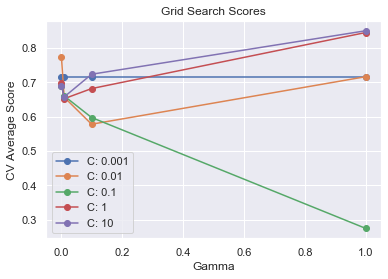

In [339]:
clf_gamma= [0.001, 0.01, 0.1, 1]
clf_C= [0.001, 0.01, 0.1, 1, 10]
plot_grid_search(svc_grid.cv_results_, clf_gamma, clf_C, 'Gamma', 'C')

In [340]:
best_svc.best_estimator_.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
       probability=False, random_state=None, shrinking=True, tol=0.001,
       verbose=False))],
 'verbose': False,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
     probability=False, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'clf__C': 10,
 'clf__break_ties': False,
 'clf__cache_size': 200,
 'clf__class_weight': 'balanced',
 'clf__coef0': 0.0,
 'clf__decision_function_shape': 'ovr',
 'clf__degree': 3,
 'clf__gamma': 1,
 'clf__k

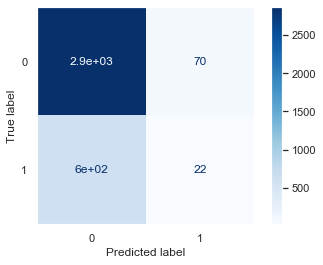

In [341]:
metrics.plot_confusion_matrix(best_svc.best_estimator_,x_test,y_test,cmap=plt.cm.Blues)
plt.grid(None)

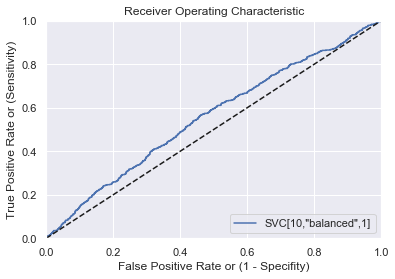

In [342]:
ROC(best_svc.best_estimator_,y_test,x_test,['gamma','C','class_weight'])

In [358]:
best_svc.best_estimator_.score(x_test,y_test)

0.8111142295818131

In [344]:
# the_pipe=Pipeline([('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
#   ('clf',
#    SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
#        decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
#        probability=False, random_state=None, shrinking=True, tol=0.001,
#        verbose=False))])

In [359]:
best_svc.best_estimator_.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

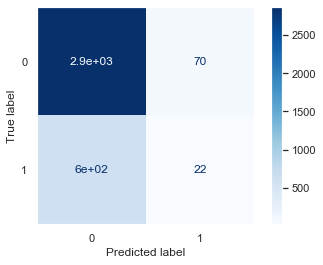

In [346]:
metrics.plot_confusion_matrix(best_svc.best_estimator_,x_test,y_test,cmap=plt.cm.Blues)
plt.grid(None)